# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [5]:
# can comment out after executing
!unzip processed_celeba_small.zip

Archive:  processed_celeba_small.zip
replace processed_celeba_small/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [8]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/0.4.0/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [9]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [10]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    transform = transforms.Compose([transforms.CenterCrop(image_size), transforms.ToTensor()])
    dataset = datasets.ImageFolder(root= data_dir, transform = transform)
    
    train_loader = torch.utils.data.DataLoader(dataset= dataset,
                                          batch_size=batch_size,
                                          shuffle=True)
    
    return train_loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [22]:
# Define function hyperparameters
batch_size = 32
img_size = 64

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

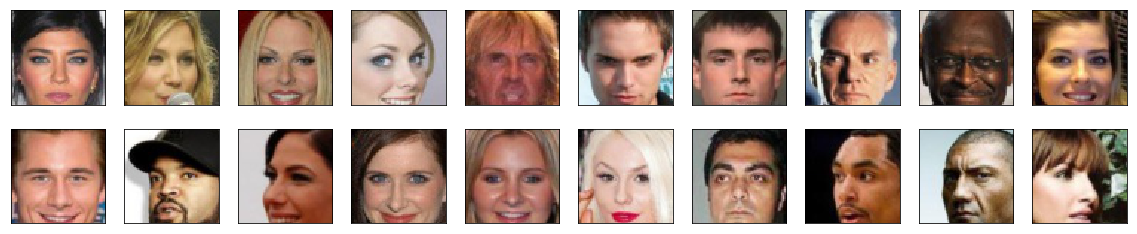

In [12]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [13]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x= x*(max-min)+min
    
    return x


In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9294)
Max:  tensor(1.)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [15]:
import torch.nn as nn
import torch.nn.functional as F

def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization."""
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
    # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [23]:
class Discriminator(nn.Module):

    
    
    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        self.conv1 = conv(3, conv_dim, 4, batch_norm = False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)
        
        self.fc = nn.Linear(conv_dim*8*4*4, 1)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        out = F.leaky_relu(self.conv4(out), 0.2)
        
        
        #flatten
        out = out.view(-1, self.conv_dim*8*4*4)
        
        out = self.fc(out)
        
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

RuntimeError: invalid argument 2: size '[-1 x 1280]' is invalid for input with 16000 elements at /opt/conda/conda-bld/pytorch_1524584710464/work/aten/src/TH/THStorage.c:37

## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [17]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
        """Creates a convolutional layer, with optional batch normalization.
        """
        layers = []
        transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
        # append conv layer
        layers.append(transpose_conv_layer)

        if batch_norm:
            # append batchnorm layer
            layers.append(nn.BatchNorm2d(out_channels))
     
        # using Sequential container
        return nn.Sequential(*layers)

In [11]:
class Generator(nn.Module):
    
    
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        self.fc = nn.Linear(z_size, conv_dim*4*8*8)
        
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim,3, 4, batch_norm=False )
        
        
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*4,4,4)
        
        # hidden transpose conv layers+ relu
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        
        # last layer + tanh activation
        out = self.t_conv3(out)
        out = F.tanh(out)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [12]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if classname.find("layer_type") != -1:

        torch.nn.init.normal_(m.weight.data, mean, std)
    
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [14]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 1000

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=1000, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bia

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [16]:
def real_loss(D_out, smooth = False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [17]:
import torch.optim as optim

lr = 0.0001
beta1=0.5
beta2=0.999

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [18]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
        
            # A. Train with real images

            # Compute the discriminator losses on real images 
            if train_on_gpu:
                real_images = real_images.cuda()

            D_real = D(real_images)
            d_real_loss = real_loss(D_real)

            # B. Train with fake images

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)

            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step() 

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
        
            # 1. Train with fake images and flipped labels

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels

            # perform backprop
            g_loss.backward()
            g_optimizer.step()

            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [19]:
# set number of epochs 
n_epochs = 40


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   40] | d_loss: 1.3303 | g_loss: 0.8151
Epoch [    1/   40] | d_loss: 0.2940 | g_loss: 2.1614
Epoch [    1/   40] | d_loss: 0.0921 | g_loss: 3.1771
Epoch [    1/   40] | d_loss: 0.0578 | g_loss: 3.7628
Epoch [    1/   40] | d_loss: 0.0337 | g_loss: 4.2559
Epoch [    1/   40] | d_loss: 0.0225 | g_loss: 4.5328
Epoch [    1/   40] | d_loss: 0.0152 | g_loss: 4.7594
Epoch [    1/   40] | d_loss: 0.0114 | g_loss: 5.1062
Epoch [    1/   40] | d_loss: 0.0105 | g_loss: 5.4094
Epoch [    1/   40] | d_loss: 0.0089 | g_loss: 5.0581
Epoch [    1/   40] | d_loss: 0.0065 | g_loss: 5.4849
Epoch [    1/   40] | d_loss: 0.0063 | g_loss: 5.6942
Epoch [    1/   40] | d_loss: 0.0055 | g_loss: 6.1047
Epoch [    1/   40] | d_loss: 0.0058 | g_loss: 5.8453
Epoch [    1/   40] | d_loss: 0.0040 | g_loss: 6.0104
Epoch [    1/   40] | d_loss: 0.0039 | g_loss: 6.1712
Epoch [    1/   40] | d_loss: 0.0032 | g_loss: 6.2053
Epoch [    1/   40] | d_loss: 0.0035 | g_loss: 6.3365
Epoch [    1/   40] | d_loss

Epoch [    2/   40] | d_loss: 0.0000 | g_loss: 12.7494
Epoch [    2/   40] | d_loss: 0.0000 | g_loss: 12.8191
Epoch [    2/   40] | d_loss: 0.0000 | g_loss: 12.7860
Epoch [    2/   40] | d_loss: 0.0000 | g_loss: 12.7416
Epoch [    2/   40] | d_loss: 0.0000 | g_loss: 12.7383
Epoch [    2/   40] | d_loss: 0.0000 | g_loss: 12.8170
Epoch [    2/   40] | d_loss: 0.0000 | g_loss: 12.7969
Epoch [    2/   40] | d_loss: 0.0000 | g_loss: 12.8381
Epoch [    2/   40] | d_loss: 0.0000 | g_loss: 12.9666
Epoch [    2/   40] | d_loss: 0.0000 | g_loss: 13.0916
Epoch [    2/   40] | d_loss: 0.0000 | g_loss: 13.1489
Epoch [    2/   40] | d_loss: 0.0000 | g_loss: 13.2528
Epoch [    2/   40] | d_loss: 0.0000 | g_loss: 13.0908
Epoch [    2/   40] | d_loss: 0.0000 | g_loss: 12.2077
Epoch [    2/   40] | d_loss: 0.0000 | g_loss: 12.0884
Epoch [    2/   40] | d_loss: 0.0000 | g_loss: 12.1310
Epoch [    2/   40] | d_loss: 0.0000 | g_loss: 12.1483
Epoch [    2/   40] | d_loss: 0.0000 | g_loss: 12.1955
Epoch [   

Epoch [    4/   40] | d_loss: 0.0000 | g_loss: 16.0498
Epoch [    4/   40] | d_loss: 0.0000 | g_loss: 16.0869
Epoch [    4/   40] | d_loss: 0.0000 | g_loss: 16.1156
Epoch [    4/   40] | d_loss: 0.0000 | g_loss: 16.2004
Epoch [    4/   40] | d_loss: 0.0000 | g_loss: 16.3358
Epoch [    4/   40] | d_loss: 0.0000 | g_loss: 16.5023
Epoch [    4/   40] | d_loss: 0.0000 | g_loss: 16.6294
Epoch [    4/   40] | d_loss: 0.0000 | g_loss: 16.7489
Epoch [    4/   40] | d_loss: 0.0000 | g_loss: 16.9210
Epoch [    4/   40] | d_loss: 0.0000 | g_loss: 17.0191
Epoch [    4/   40] | d_loss: 0.0000 | g_loss: 17.0724
Epoch [    4/   40] | d_loss: 0.0000 | g_loss: 17.0953
Epoch [    4/   40] | d_loss: 0.0000 | g_loss: 17.0811
Epoch [    4/   40] | d_loss: 0.0000 | g_loss: 17.0560
Epoch [    4/   40] | d_loss: 0.0000 | g_loss: 17.0438
Epoch [    4/   40] | d_loss: 0.0000 | g_loss: 17.0818
Epoch [    4/   40] | d_loss: 0.0000 | g_loss: 17.0912
Epoch [    4/   40] | d_loss: 0.0000 | g_loss: 17.1093
Epoch [   

Epoch [    5/   40] | d_loss: 0.0000 | g_loss: 17.1798
Epoch [    6/   40] | d_loss: 0.0000 | g_loss: 17.1861
Epoch [    6/   40] | d_loss: 0.0000 | g_loss: 17.1957
Epoch [    6/   40] | d_loss: 0.0000 | g_loss: 17.1882
Epoch [    6/   40] | d_loss: 0.0000 | g_loss: 17.1616
Epoch [    6/   40] | d_loss: 0.0000 | g_loss: 17.1802
Epoch [    6/   40] | d_loss: 0.0000 | g_loss: 17.1706
Epoch [    6/   40] | d_loss: 0.0000 | g_loss: 17.1642
Epoch [    6/   40] | d_loss: 0.0000 | g_loss: 17.1763
Epoch [    6/   40] | d_loss: 0.0000 | g_loss: 17.1753
Epoch [    6/   40] | d_loss: 0.0000 | g_loss: 17.1715
Epoch [    6/   40] | d_loss: 0.0000 | g_loss: 17.1600
Epoch [    6/   40] | d_loss: 0.0000 | g_loss: 17.1665
Epoch [    6/   40] | d_loss: 0.0000 | g_loss: 17.1793
Epoch [    6/   40] | d_loss: 0.0000 | g_loss: 17.1675
Epoch [    6/   40] | d_loss: 0.0000 | g_loss: 17.1668
Epoch [    6/   40] | d_loss: 0.0000 | g_loss: 17.1691
Epoch [    6/   40] | d_loss: 0.0000 | g_loss: 17.1512
Epoch [   

Epoch [    7/   40] | d_loss: 0.0000 | g_loss: 17.1910
Epoch [    7/   40] | d_loss: 0.0000 | g_loss: 17.1793
Epoch [    7/   40] | d_loss: 0.0000 | g_loss: 17.1985
Epoch [    7/   40] | d_loss: 0.0000 | g_loss: 17.1908
Epoch [    7/   40] | d_loss: 0.0000 | g_loss: 17.1747
Epoch [    7/   40] | d_loss: 0.0000 | g_loss: 17.2033
Epoch [    7/   40] | d_loss: 0.0000 | g_loss: 17.2000
Epoch [    7/   40] | d_loss: 0.0000 | g_loss: 17.1858
Epoch [    7/   40] | d_loss: 0.0000 | g_loss: 17.1677
Epoch [    7/   40] | d_loss: 0.0000 | g_loss: 17.2017
Epoch [    7/   40] | d_loss: 0.0000 | g_loss: 17.1814
Epoch [    7/   40] | d_loss: 0.0000 | g_loss: 17.2019
Epoch [    7/   40] | d_loss: 0.0000 | g_loss: 17.1925
Epoch [    7/   40] | d_loss: 0.0000 | g_loss: 17.1855
Epoch [    7/   40] | d_loss: 0.0000 | g_loss: 17.1759
Epoch [    7/   40] | d_loss: 0.0000 | g_loss: 17.1734
Epoch [    7/   40] | d_loss: 0.0000 | g_loss: 17.2131
Epoch [    7/   40] | d_loss: 0.0000 | g_loss: 17.2012
Epoch [   

Epoch [    9/   40] | d_loss: 0.0000 | g_loss: 17.1582
Epoch [    9/   40] | d_loss: 0.0000 | g_loss: 17.2117
Epoch [    9/   40] | d_loss: 0.0000 | g_loss: 17.1977
Epoch [    9/   40] | d_loss: 0.0000 | g_loss: 17.1779
Epoch [    9/   40] | d_loss: 0.0000 | g_loss: 17.1740
Epoch [    9/   40] | d_loss: 0.0000 | g_loss: 17.1624
Epoch [    9/   40] | d_loss: 0.0000 | g_loss: 17.1596
Epoch [    9/   40] | d_loss: 0.0000 | g_loss: 17.1463
Epoch [    9/   40] | d_loss: 0.0000 | g_loss: 17.2045
Epoch [    9/   40] | d_loss: 0.0000 | g_loss: 17.1925
Epoch [    9/   40] | d_loss: 0.0000 | g_loss: 17.2014
Epoch [    9/   40] | d_loss: 0.0000 | g_loss: 17.1934
Epoch [    9/   40] | d_loss: 0.0000 | g_loss: 17.1812
Epoch [    9/   40] | d_loss: 0.0000 | g_loss: 17.1724
Epoch [    9/   40] | d_loss: 0.0000 | g_loss: 17.1791
Epoch [    9/   40] | d_loss: 0.0000 | g_loss: 17.1667
Epoch [    9/   40] | d_loss: 0.0000 | g_loss: 17.1632
Epoch [    9/   40] | d_loss: 0.0000 | g_loss: 17.1564
Epoch [   

Epoch [   10/   40] | d_loss: 0.0000 | g_loss: 17.1723
Epoch [   10/   40] | d_loss: 0.0000 | g_loss: 17.1678
Epoch [   10/   40] | d_loss: 0.0000 | g_loss: 17.1533
Epoch [   10/   40] | d_loss: 0.0000 | g_loss: 17.1410
Epoch [   11/   40] | d_loss: 0.0000 | g_loss: 17.1408
Epoch [   11/   40] | d_loss: 0.0000 | g_loss: 17.1326
Epoch [   11/   40] | d_loss: 0.0000 | g_loss: 17.1806
Epoch [   11/   40] | d_loss: 0.0000 | g_loss: 17.1776
Epoch [   11/   40] | d_loss: 0.0000 | g_loss: 17.1690
Epoch [   11/   40] | d_loss: 0.0000 | g_loss: 17.1669
Epoch [   11/   40] | d_loss: 0.0000 | g_loss: 17.1647
Epoch [   11/   40] | d_loss: 0.0000 | g_loss: 17.1488
Epoch [   11/   40] | d_loss: 0.0000 | g_loss: 17.1391
Epoch [   11/   40] | d_loss: 0.0000 | g_loss: 17.1752
Epoch [   11/   40] | d_loss: 0.0000 | g_loss: 17.1717
Epoch [   11/   40] | d_loss: 0.0000 | g_loss: 17.1772
Epoch [   11/   40] | d_loss: 0.0000 | g_loss: 17.1575
Epoch [   11/   40] | d_loss: 0.0000 | g_loss: 17.1491
Epoch [   

Epoch [   12/   40] | d_loss: 0.0000 | g_loss: 17.3090
Epoch [   12/   40] | d_loss: 0.0000 | g_loss: 17.2979
Epoch [   12/   40] | d_loss: 0.0000 | g_loss: 17.2796
Epoch [   12/   40] | d_loss: 0.0000 | g_loss: 17.2685
Epoch [   12/   40] | d_loss: 0.0000 | g_loss: 17.2573
Epoch [   12/   40] | d_loss: 0.0000 | g_loss: 17.2360
Epoch [   12/   40] | d_loss: 0.0000 | g_loss: 17.2347
Epoch [   12/   40] | d_loss: 0.0000 | g_loss: 17.2241
Epoch [   12/   40] | d_loss: 0.0000 | g_loss: 17.2044
Epoch [   12/   40] | d_loss: 0.0000 | g_loss: 17.2060
Epoch [   12/   40] | d_loss: 0.0000 | g_loss: 17.1991
Epoch [   12/   40] | d_loss: 0.0000 | g_loss: 17.1781
Epoch [   12/   40] | d_loss: 0.0000 | g_loss: 17.1649
Epoch [   12/   40] | d_loss: 0.0000 | g_loss: 17.1561
Epoch [   12/   40] | d_loss: 0.0000 | g_loss: 17.2016
Epoch [   12/   40] | d_loss: 0.0000 | g_loss: 17.1827
Epoch [   12/   40] | d_loss: 0.0000 | g_loss: 17.1664
Epoch [   12/   40] | d_loss: 0.0000 | g_loss: 17.1585
Epoch [   

Epoch [   14/   40] | d_loss: 0.0000 | g_loss: 17.1738
Epoch [   14/   40] | d_loss: 0.0000 | g_loss: 17.1695
Epoch [   14/   40] | d_loss: 0.0000 | g_loss: 17.1705
Epoch [   14/   40] | d_loss: 0.0000 | g_loss: 17.1642
Epoch [   14/   40] | d_loss: 0.0000 | g_loss: 17.1553
Epoch [   14/   40] | d_loss: 0.0000 | g_loss: 17.1670
Epoch [   14/   40] | d_loss: 0.0000 | g_loss: 17.2264
Epoch [   14/   40] | d_loss: 0.0000 | g_loss: 17.2252
Epoch [   14/   40] | d_loss: 0.0000 | g_loss: 17.2221
Epoch [   14/   40] | d_loss: 0.0000 | g_loss: 17.2275
Epoch [   14/   40] | d_loss: 0.0000 | g_loss: 17.2220
Epoch [   14/   40] | d_loss: 0.0000 | g_loss: 17.2153
Epoch [   14/   40] | d_loss: 0.0000 | g_loss: 17.2140
Epoch [   14/   40] | d_loss: 0.0000 | g_loss: 17.2119
Epoch [   14/   40] | d_loss: 0.0000 | g_loss: 17.2138
Epoch [   14/   40] | d_loss: 0.0000 | g_loss: 17.2162
Epoch [   14/   40] | d_loss: 0.0000 | g_loss: 17.2185
Epoch [   14/   40] | d_loss: 0.0000 | g_loss: 17.2160
Epoch [   

Epoch [   15/   40] | d_loss: 0.0000 | g_loss: 17.1596
Epoch [   15/   40] | d_loss: 0.0000 | g_loss: 17.1583
Epoch [   15/   40] | d_loss: 0.0000 | g_loss: 17.1626
Epoch [   15/   40] | d_loss: 0.0000 | g_loss: 17.1507
Epoch [   15/   40] | d_loss: 0.0000 | g_loss: 17.2212
Epoch [   15/   40] | d_loss: 0.0000 | g_loss: 17.2254
Epoch [   15/   40] | d_loss: 0.0000 | g_loss: 17.2282
Epoch [   16/   40] | d_loss: 0.0000 | g_loss: 17.2121
Epoch [   16/   40] | d_loss: 0.0000 | g_loss: 17.2125
Epoch [   16/   40] | d_loss: 0.0000 | g_loss: 17.2046
Epoch [   16/   40] | d_loss: 0.0000 | g_loss: 17.2091
Epoch [   16/   40] | d_loss: 0.0000 | g_loss: 17.2118
Epoch [   16/   40] | d_loss: 0.0000 | g_loss: 17.2060
Epoch [   16/   40] | d_loss: 0.0000 | g_loss: 17.2103
Epoch [   16/   40] | d_loss: 0.0000 | g_loss: 17.2061
Epoch [   16/   40] | d_loss: 0.0000 | g_loss: 17.1937
Epoch [   16/   40] | d_loss: 0.0000 | g_loss: 17.1912
Epoch [   16/   40] | d_loss: 0.0000 | g_loss: 17.1980
Epoch [   

Epoch [   17/   40] | d_loss: 0.0000 | g_loss: 17.1874
Epoch [   17/   40] | d_loss: 0.0000 | g_loss: 17.1933
Epoch [   17/   40] | d_loss: 0.0000 | g_loss: 17.1873
Epoch [   17/   40] | d_loss: 0.0000 | g_loss: 17.1785
Epoch [   17/   40] | d_loss: 0.0000 | g_loss: 17.1886
Epoch [   17/   40] | d_loss: 0.0000 | g_loss: 17.1820
Epoch [   17/   40] | d_loss: 0.0000 | g_loss: 17.1924
Epoch [   17/   40] | d_loss: 0.0000 | g_loss: 17.1822
Epoch [   17/   40] | d_loss: 0.0000 | g_loss: 17.1897
Epoch [   17/   40] | d_loss: 0.0000 | g_loss: 17.1914
Epoch [   17/   40] | d_loss: 0.0000 | g_loss: 17.1782
Epoch [   17/   40] | d_loss: 0.0000 | g_loss: 17.1838
Epoch [   17/   40] | d_loss: 0.0000 | g_loss: 17.1757
Epoch [   17/   40] | d_loss: 0.0000 | g_loss: 17.1799
Epoch [   17/   40] | d_loss: 0.0000 | g_loss: 17.1789
Epoch [   17/   40] | d_loss: 0.0000 | g_loss: 17.1751
Epoch [   17/   40] | d_loss: 0.0000 | g_loss: 17.1716
Epoch [   17/   40] | d_loss: 0.0000 | g_loss: 17.1744
Epoch [   

Epoch [   19/   40] | d_loss: 0.0000 | g_loss: 17.1994
Epoch [   19/   40] | d_loss: 0.0000 | g_loss: 17.1986
Epoch [   19/   40] | d_loss: 0.0000 | g_loss: 17.1957
Epoch [   19/   40] | d_loss: 0.0000 | g_loss: 17.1900
Epoch [   19/   40] | d_loss: 0.0000 | g_loss: 17.2079
Epoch [   19/   40] | d_loss: 0.0000 | g_loss: 17.1958
Epoch [   19/   40] | d_loss: 0.0000 | g_loss: 17.1898
Epoch [   19/   40] | d_loss: 0.0000 | g_loss: 17.1889
Epoch [   19/   40] | d_loss: 0.0000 | g_loss: 17.1943
Epoch [   19/   40] | d_loss: 0.0000 | g_loss: 17.1940
Epoch [   19/   40] | d_loss: 0.0000 | g_loss: 17.1937
Epoch [   19/   40] | d_loss: 0.0000 | g_loss: 17.1958
Epoch [   19/   40] | d_loss: 0.0000 | g_loss: 17.1921
Epoch [   19/   40] | d_loss: 0.0000 | g_loss: 17.1874
Epoch [   19/   40] | d_loss: 0.0000 | g_loss: 17.1944
Epoch [   19/   40] | d_loss: 0.0000 | g_loss: 17.1895
Epoch [   19/   40] | d_loss: 0.0000 | g_loss: 17.1864
Epoch [   19/   40] | d_loss: 0.0000 | g_loss: 17.1796
Epoch [   

Epoch [   20/   40] | d_loss: 0.0000 | g_loss: 17.1961
Epoch [   20/   40] | d_loss: 0.0000 | g_loss: 17.1912
Epoch [   20/   40] | d_loss: 0.0000 | g_loss: 17.1887
Epoch [   20/   40] | d_loss: 0.0000 | g_loss: 17.1860
Epoch [   20/   40] | d_loss: 0.0000 | g_loss: 17.1927
Epoch [   20/   40] | d_loss: 0.0000 | g_loss: 17.1871
Epoch [   20/   40] | d_loss: 0.0000 | g_loss: 17.1970
Epoch [   20/   40] | d_loss: 0.0000 | g_loss: 17.1918
Epoch [   20/   40] | d_loss: 0.0000 | g_loss: 17.1939
Epoch [   20/   40] | d_loss: 0.0000 | g_loss: 17.1906
Epoch [   21/   40] | d_loss: 0.0000 | g_loss: 17.2035
Epoch [   21/   40] | d_loss: 0.0000 | g_loss: 17.1907
Epoch [   21/   40] | d_loss: 0.0000 | g_loss: 17.1885
Epoch [   21/   40] | d_loss: 0.0000 | g_loss: 17.1896
Epoch [   21/   40] | d_loss: 0.0000 | g_loss: 17.1855
Epoch [   21/   40] | d_loss: 0.0000 | g_loss: 17.1857
Epoch [   21/   40] | d_loss: 0.0000 | g_loss: 17.1873
Epoch [   21/   40] | d_loss: 0.0000 | g_loss: 17.1842
Epoch [   

Epoch [   22/   40] | d_loss: 0.0000 | g_loss: 17.1930
Epoch [   22/   40] | d_loss: 0.0000 | g_loss: 17.1871
Epoch [   22/   40] | d_loss: 0.0000 | g_loss: 17.1875
Epoch [   22/   40] | d_loss: 0.0000 | g_loss: 17.1929
Epoch [   22/   40] | d_loss: 0.0000 | g_loss: 17.1895
Epoch [   22/   40] | d_loss: 0.0000 | g_loss: 17.1878
Epoch [   22/   40] | d_loss: 0.0000 | g_loss: 17.1946
Epoch [   22/   40] | d_loss: 0.0000 | g_loss: 17.1876
Epoch [   22/   40] | d_loss: 0.0000 | g_loss: 17.1927
Epoch [   22/   40] | d_loss: 0.0000 | g_loss: 17.1890
Epoch [   22/   40] | d_loss: 0.0000 | g_loss: 17.1842
Epoch [   22/   40] | d_loss: 0.0000 | g_loss: 17.1879
Epoch [   22/   40] | d_loss: 0.0000 | g_loss: 17.1840
Epoch [   22/   40] | d_loss: 0.0000 | g_loss: 17.1805
Epoch [   22/   40] | d_loss: 0.0000 | g_loss: 17.1811
Epoch [   22/   40] | d_loss: 0.0000 | g_loss: 17.1889
Epoch [   22/   40] | d_loss: 0.0000 | g_loss: 17.1772
Epoch [   22/   40] | d_loss: 0.0000 | g_loss: 17.1851
Epoch [   

Epoch [   24/   40] | d_loss: 0.0000 | g_loss: 17.2099
Epoch [   24/   40] | d_loss: 0.0000 | g_loss: 17.2037
Epoch [   24/   40] | d_loss: 0.0000 | g_loss: 17.2167
Epoch [   24/   40] | d_loss: 0.0000 | g_loss: 17.2129
Epoch [   24/   40] | d_loss: 0.0000 | g_loss: 17.2049
Epoch [   24/   40] | d_loss: 0.0000 | g_loss: 17.2051
Epoch [   24/   40] | d_loss: 0.0000 | g_loss: 17.2036
Epoch [   24/   40] | d_loss: 0.0000 | g_loss: 17.2075
Epoch [   24/   40] | d_loss: 0.0000 | g_loss: 17.2053
Epoch [   24/   40] | d_loss: 0.0000 | g_loss: 17.2078
Epoch [   24/   40] | d_loss: 0.0000 | g_loss: 17.2113
Epoch [   24/   40] | d_loss: 0.0000 | g_loss: 17.2027
Epoch [   24/   40] | d_loss: 0.0000 | g_loss: 17.2047
Epoch [   24/   40] | d_loss: 0.0000 | g_loss: 17.2054
Epoch [   24/   40] | d_loss: 0.0000 | g_loss: 17.2073
Epoch [   24/   40] | d_loss: 0.0000 | g_loss: 17.1980
Epoch [   24/   40] | d_loss: 0.0000 | g_loss: 17.2156
Epoch [   24/   40] | d_loss: 0.0000 | g_loss: 17.2030
Epoch [   

Epoch [   25/   40] | d_loss: 0.0000 | g_loss: 17.1931
Epoch [   25/   40] | d_loss: 0.0000 | g_loss: 17.1790
Epoch [   25/   40] | d_loss: 0.0000 | g_loss: 17.1756
Epoch [   25/   40] | d_loss: 0.0000 | g_loss: 17.1744
Epoch [   25/   40] | d_loss: 0.0000 | g_loss: 17.1869
Epoch [   25/   40] | d_loss: 0.0000 | g_loss: 17.1813
Epoch [   25/   40] | d_loss: 0.0000 | g_loss: 17.1757
Epoch [   25/   40] | d_loss: 0.0000 | g_loss: 17.1756
Epoch [   25/   40] | d_loss: 0.0000 | g_loss: 17.1741
Epoch [   25/   40] | d_loss: 0.0000 | g_loss: 17.1757
Epoch [   25/   40] | d_loss: 0.0000 | g_loss: 17.1728
Epoch [   25/   40] | d_loss: 0.0000 | g_loss: 17.1713
Epoch [   25/   40] | d_loss: 0.0000 | g_loss: 17.1672
Epoch [   26/   40] | d_loss: 0.0000 | g_loss: 17.1890
Epoch [   26/   40] | d_loss: 0.0000 | g_loss: 17.1713
Epoch [   26/   40] | d_loss: 0.0000 | g_loss: 17.1840
Epoch [   26/   40] | d_loss: 0.0000 | g_loss: 17.1697
Epoch [   26/   40] | d_loss: 0.0000 | g_loss: 17.1653
Epoch [   

Epoch [   27/   40] | d_loss: 0.0000 | g_loss: 17.2222
Epoch [   27/   40] | d_loss: 0.0000 | g_loss: 17.2157
Epoch [   27/   40] | d_loss: 0.0000 | g_loss: 17.2209
Epoch [   27/   40] | d_loss: 0.0000 | g_loss: 17.2128
Epoch [   27/   40] | d_loss: 0.0000 | g_loss: 17.2128
Epoch [   27/   40] | d_loss: 0.0000 | g_loss: 17.2107
Epoch [   27/   40] | d_loss: 0.0000 | g_loss: 17.2134
Epoch [   27/   40] | d_loss: 0.0000 | g_loss: 17.2075
Epoch [   27/   40] | d_loss: 0.0000 | g_loss: 17.2135
Epoch [   27/   40] | d_loss: 0.0000 | g_loss: 17.2052
Epoch [   27/   40] | d_loss: 0.0000 | g_loss: 17.2096
Epoch [   27/   40] | d_loss: 0.0000 | g_loss: 17.2166
Epoch [   27/   40] | d_loss: 0.0000 | g_loss: 17.2231
Epoch [   27/   40] | d_loss: 0.0000 | g_loss: 17.2189
Epoch [   27/   40] | d_loss: 0.0000 | g_loss: 17.2065
Epoch [   27/   40] | d_loss: 0.0000 | g_loss: 17.2097
Epoch [   27/   40] | d_loss: 0.0000 | g_loss: 17.2120
Epoch [   27/   40] | d_loss: 0.0000 | g_loss: 17.2180
Epoch [   

Epoch [   29/   40] | d_loss: 0.0000 | g_loss: 17.1768
Epoch [   29/   40] | d_loss: 0.0000 | g_loss: 17.1831
Epoch [   29/   40] | d_loss: 0.0000 | g_loss: 17.1875
Epoch [   29/   40] | d_loss: 0.0000 | g_loss: 17.1818
Epoch [   29/   40] | d_loss: 0.0000 | g_loss: 17.1739
Epoch [   29/   40] | d_loss: 0.0000 | g_loss: 17.1822
Epoch [   29/   40] | d_loss: 0.0000 | g_loss: 17.1808
Epoch [   29/   40] | d_loss: 0.0000 | g_loss: 17.1823
Epoch [   29/   40] | d_loss: 0.0000 | g_loss: 17.1726
Epoch [   29/   40] | d_loss: 0.0000 | g_loss: 17.1736
Epoch [   29/   40] | d_loss: 0.0000 | g_loss: 17.1816
Epoch [   29/   40] | d_loss: 0.0000 | g_loss: 17.1817
Epoch [   29/   40] | d_loss: 0.0000 | g_loss: 17.1794
Epoch [   29/   40] | d_loss: 0.0000 | g_loss: 17.1787
Epoch [   29/   40] | d_loss: 0.0000 | g_loss: 17.1752
Epoch [   29/   40] | d_loss: 0.0000 | g_loss: 17.1801
Epoch [   29/   40] | d_loss: 0.0000 | g_loss: 17.1679
Epoch [   29/   40] | d_loss: 0.0000 | g_loss: 17.1771
Epoch [   

Epoch [   30/   40] | d_loss: 0.0000 | g_loss: 17.1416
Epoch [   30/   40] | d_loss: 0.0000 | g_loss: 17.1558
Epoch [   30/   40] | d_loss: 0.0000 | g_loss: 17.1566
Epoch [   30/   40] | d_loss: 0.0000 | g_loss: 17.1475
Epoch [   30/   40] | d_loss: 0.0000 | g_loss: 17.1491
Epoch [   30/   40] | d_loss: 0.0000 | g_loss: 17.1507
Epoch [   30/   40] | d_loss: 0.0000 | g_loss: 17.1459
Epoch [   30/   40] | d_loss: 0.0000 | g_loss: 17.1433
Epoch [   30/   40] | d_loss: 0.0000 | g_loss: 17.1468
Epoch [   30/   40] | d_loss: 0.0000 | g_loss: 17.1549
Epoch [   30/   40] | d_loss: 0.0000 | g_loss: 17.1573
Epoch [   30/   40] | d_loss: 0.0000 | g_loss: 17.1395
Epoch [   30/   40] | d_loss: 0.0000 | g_loss: 17.1443
Epoch [   30/   40] | d_loss: 0.0000 | g_loss: 17.1504
Epoch [   30/   40] | d_loss: 0.0000 | g_loss: 17.1513
Epoch [   30/   40] | d_loss: 0.0000 | g_loss: 17.2224
Epoch [   31/   40] | d_loss: 0.0000 | g_loss: 17.2228
Epoch [   31/   40] | d_loss: 0.0000 | g_loss: 17.2204
Epoch [   

Epoch [   32/   40] | d_loss: 0.0000 | g_loss: 17.1986
Epoch [   32/   40] | d_loss: 0.0000 | g_loss: 17.1859
Epoch [   32/   40] | d_loss: 0.0000 | g_loss: 17.1963
Epoch [   32/   40] | d_loss: 0.0000 | g_loss: 17.1951
Epoch [   32/   40] | d_loss: 0.0000 | g_loss: 17.1954
Epoch [   32/   40] | d_loss: 0.0000 | g_loss: 17.1947
Epoch [   32/   40] | d_loss: 0.0000 | g_loss: 17.1869
Epoch [   32/   40] | d_loss: 0.0000 | g_loss: 17.1934
Epoch [   32/   40] | d_loss: 0.0000 | g_loss: 17.1904
Epoch [   32/   40] | d_loss: 0.0000 | g_loss: 17.1965
Epoch [   32/   40] | d_loss: 0.0000 | g_loss: 17.1941
Epoch [   32/   40] | d_loss: 0.0000 | g_loss: 17.1936
Epoch [   32/   40] | d_loss: 0.0000 | g_loss: 17.1919
Epoch [   32/   40] | d_loss: 0.0000 | g_loss: 17.1896
Epoch [   32/   40] | d_loss: 0.0000 | g_loss: 17.1853
Epoch [   32/   40] | d_loss: 0.0000 | g_loss: 17.1896
Epoch [   32/   40] | d_loss: 0.0000 | g_loss: 17.1890
Epoch [   32/   40] | d_loss: 0.0000 | g_loss: 17.1949
Epoch [   

Epoch [   34/   40] | d_loss: 0.0000 | g_loss: 17.1784
Epoch [   34/   40] | d_loss: 0.0000 | g_loss: 17.1675
Epoch [   34/   40] | d_loss: 0.0000 | g_loss: 17.1675
Epoch [   34/   40] | d_loss: 0.0000 | g_loss: 17.1660
Epoch [   34/   40] | d_loss: 0.0000 | g_loss: 17.1752
Epoch [   34/   40] | d_loss: 0.0000 | g_loss: 17.1733
Epoch [   34/   40] | d_loss: 0.0000 | g_loss: 17.1697
Epoch [   34/   40] | d_loss: 0.0000 | g_loss: 17.1722
Epoch [   34/   40] | d_loss: 0.0000 | g_loss: 17.1651
Epoch [   34/   40] | d_loss: 0.0000 | g_loss: 17.1754
Epoch [   34/   40] | d_loss: 0.0000 | g_loss: 17.1690
Epoch [   34/   40] | d_loss: 0.0000 | g_loss: 17.1688
Epoch [   34/   40] | d_loss: 0.0000 | g_loss: 17.1694
Epoch [   34/   40] | d_loss: 0.0000 | g_loss: 17.1694
Epoch [   34/   40] | d_loss: 0.0000 | g_loss: 17.1639
Epoch [   34/   40] | d_loss: 0.0000 | g_loss: 17.1740
Epoch [   34/   40] | d_loss: 0.0000 | g_loss: 17.1735
Epoch [   34/   40] | d_loss: 0.0000 | g_loss: 17.1659
Epoch [   

Epoch [   35/   40] | d_loss: 0.0000 | g_loss: 17.1557
Epoch [   35/   40] | d_loss: 0.0000 | g_loss: 17.1571
Epoch [   35/   40] | d_loss: 0.0000 | g_loss: 17.1546
Epoch [   35/   40] | d_loss: 0.0000 | g_loss: 17.1500
Epoch [   35/   40] | d_loss: 0.0000 | g_loss: 17.1566
Epoch [   35/   40] | d_loss: 0.0000 | g_loss: 17.1536
Epoch [   35/   40] | d_loss: 0.0000 | g_loss: 17.1552
Epoch [   35/   40] | d_loss: 0.0000 | g_loss: 17.1514
Epoch [   35/   40] | d_loss: 0.0000 | g_loss: 17.1568
Epoch [   35/   40] | d_loss: 0.0000 | g_loss: 17.1661
Epoch [   35/   40] | d_loss: 0.0000 | g_loss: 17.1638
Epoch [   35/   40] | d_loss: 0.0000 | g_loss: 17.1561
Epoch [   35/   40] | d_loss: 0.0000 | g_loss: 17.1511
Epoch [   35/   40] | d_loss: 0.0000 | g_loss: 17.1516
Epoch [   35/   40] | d_loss: 0.0000 | g_loss: 17.1585
Epoch [   35/   40] | d_loss: 0.0000 | g_loss: 17.1520
Epoch [   35/   40] | d_loss: 0.0000 | g_loss: 17.1612
Epoch [   35/   40] | d_loss: 0.0000 | g_loss: 17.1536
Epoch [   

Epoch [   37/   40] | d_loss: 0.0000 | g_loss: 17.2214
Epoch [   37/   40] | d_loss: 0.0000 | g_loss: 17.2253
Epoch [   37/   40] | d_loss: 0.0000 | g_loss: 17.2276
Epoch [   37/   40] | d_loss: 0.0000 | g_loss: 17.2215
Epoch [   37/   40] | d_loss: 0.0000 | g_loss: 17.2198
Epoch [   37/   40] | d_loss: 0.0000 | g_loss: 17.2219
Epoch [   37/   40] | d_loss: 0.0000 | g_loss: 17.2270
Epoch [   37/   40] | d_loss: 0.0000 | g_loss: 17.2215
Epoch [   37/   40] | d_loss: 0.0000 | g_loss: 17.2255
Epoch [   37/   40] | d_loss: 0.0000 | g_loss: 17.2292
Epoch [   37/   40] | d_loss: 0.0000 | g_loss: 17.2279
Epoch [   37/   40] | d_loss: 0.0000 | g_loss: 17.2282
Epoch [   37/   40] | d_loss: 0.0000 | g_loss: 17.2261
Epoch [   37/   40] | d_loss: 0.0000 | g_loss: 17.2210
Epoch [   37/   40] | d_loss: 0.0000 | g_loss: 17.2332
Epoch [   37/   40] | d_loss: 0.0000 | g_loss: 17.2257
Epoch [   37/   40] | d_loss: 0.0000 | g_loss: 17.2179
Epoch [   37/   40] | d_loss: 0.0000 | g_loss: 17.2170
Epoch [   

Epoch [   39/   40] | d_loss: 0.0000 | g_loss: 17.2142
Epoch [   39/   40] | d_loss: 0.0000 | g_loss: 17.2227
Epoch [   39/   40] | d_loss: 0.0000 | g_loss: 17.2144
Epoch [   39/   40] | d_loss: 0.0000 | g_loss: 17.2187
Epoch [   39/   40] | d_loss: 0.0000 | g_loss: 17.2216
Epoch [   39/   40] | d_loss: 0.0000 | g_loss: 17.2194
Epoch [   39/   40] | d_loss: 0.0000 | g_loss: 17.2260
Epoch [   39/   40] | d_loss: 0.0000 | g_loss: 17.2118
Epoch [   39/   40] | d_loss: 0.0000 | g_loss: 17.2155
Epoch [   39/   40] | d_loss: 0.0000 | g_loss: 17.2225
Epoch [   39/   40] | d_loss: 0.0000 | g_loss: 17.2140
Epoch [   39/   40] | d_loss: 0.0000 | g_loss: 17.2185
Epoch [   39/   40] | d_loss: 0.0000 | g_loss: 17.2145
Epoch [   39/   40] | d_loss: 0.0000 | g_loss: 17.2113
Epoch [   39/   40] | d_loss: 0.0000 | g_loss: 17.2113
Epoch [   39/   40] | d_loss: 0.0000 | g_loss: 17.2115
Epoch [   39/   40] | d_loss: 0.0000 | g_loss: 17.2167
Epoch [   39/   40] | d_loss: 0.0000 | g_loss: 17.2126
Epoch [   

Epoch [   40/   40] | d_loss: 0.0000 | g_loss: 17.2096
Epoch [   40/   40] | d_loss: 0.0000 | g_loss: 17.2068
Epoch [   40/   40] | d_loss: 0.0000 | g_loss: 17.2125
Epoch [   40/   40] | d_loss: 0.0000 | g_loss: 17.2123
Epoch [   40/   40] | d_loss: 0.0000 | g_loss: 17.2104
Epoch [   40/   40] | d_loss: 0.0000 | g_loss: 17.2106
Epoch [   40/   40] | d_loss: 0.0000 | g_loss: 17.2072
Epoch [   40/   40] | d_loss: 0.0000 | g_loss: 17.2061
Epoch [   40/   40] | d_loss: 0.0000 | g_loss: 17.2019
Epoch [   40/   40] | d_loss: 0.0000 | g_loss: 17.2013
Epoch [   40/   40] | d_loss: 0.0000 | g_loss: 17.2023
Epoch [   40/   40] | d_loss: 0.0000 | g_loss: 17.2037
Epoch [   40/   40] | d_loss: 0.0000 | g_loss: 17.2082
Epoch [   40/   40] | d_loss: 0.0000 | g_loss: 17.2028
Epoch [   40/   40] | d_loss: 0.0000 | g_loss: 17.2080
Epoch [   40/   40] | d_loss: 0.0000 | g_loss: 17.2052
Epoch [   40/   40] | d_loss: 0.0000 | g_loss: 17.2025
Epoch [   40/   40] | d_loss: 0.0000 | g_loss: 17.1973
Epoch [   

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

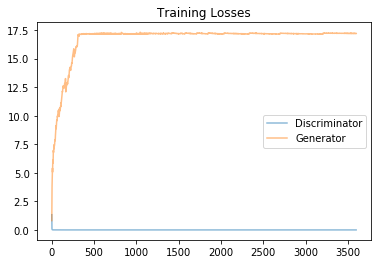

In [20]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [21]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [22]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

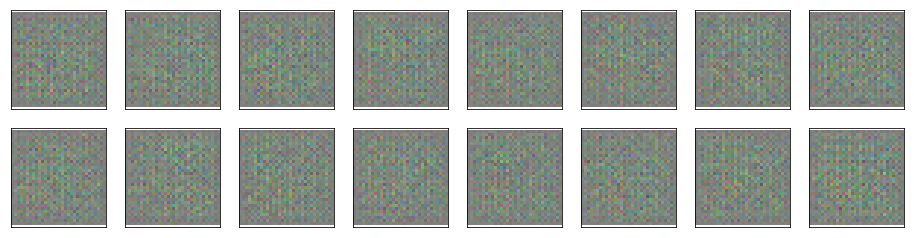

In [25]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.